# Project

In [1]:
import requests
import json
import prettytable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# code to: decode Months and Dates

In [2]:
code2month = {
    "M01" : "January",
    "M02" : "February",
    "M03" : "March",
    "M04" : "April",
    "M05" : "May",
    "M06" : "June",
    "M07" : "July",
    "M08" : "August",
    "M09" : "September",
    "M10" : "October",
    "M11" : "November",
    "M12" : "December"
}

month2number = {
    "January" : "01",
    "February" : "02",
    "March" : "03",
    "April" : "04",
    "May" : "05",
    "June" : "06",
    "July" : "07",
    "August" : "08",
    "September" : "09",
    "October" : "10",
    "November" : "11",
    "December" : "12"
}

def dateFrom(year, month):
    return "{}/{}".format(year,month2number[month])


# code to: decode the City/Town

In [3]:
code2citytown = {}
citytown2code = {}

file = open("bls-cities-and-towns.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, citytownstate = line.rstrip().split(">", 2)[1].split(" ",2)
    citytown, state = citytownstate.split(",")
    code2citytown[code]=citytown
    citytown2code[citytown]=code
    #print("line: {} code: {} citytownstate: {}, citytown: {}, state: {}".format(count, code, citytownstate, citytown, state))

file.close()

def decodeCityTown(s):
    code = s[3:len(s)-2]
    return code2citytown[code]

import re
def searchDictionary(d, city):
    #print("searching for:", city)
    res = []
    for key in d.keys():
        if re.match(city, key):
            res.append(d[key])
    return res

def findCityTownCode(city):
    return searchDictionary(citytown2code, city)

def trimCityName(city):
    return city.replace(" city","").replace(" County/city","")

In [4]:
city = "Dallas"
code = findCityTownCode(city)
print("city: {} trim: {} code: {}".format(city, trimCityName(city), code))

city: Dallas trim: Dallas code: ['CT4819000000000']


# code to: decode the State

In [5]:
code2state = {}

file = open("bls-state-codes.raw", "r")

count = 0
for line in file.readlines():
    count += 1
    ignore, code, state = line.rstrip().split(">", 2)[1].split(" ",2)
    code2state[code]=state
    #print("line: {} code: {} state: {}".format(count, code, state))

file.close()

def decodeState(s):
    code = s[5:7]
    return code2state[code]


# code to: decode the Measure

In [6]:
code2measure = {
    "03" : "unemployment-rate",
    "04" : "unemployment",
    "05" : "employment",
    "06" : "labor-force"
}

measure2Code = {
    "unemployment-rate" : "03",
    "unemployment" : "04",
    "employment" : "05",
    "labor-force" : "06"
}

def findMeasureCode(s):
    return measure2Code[s]

def decodeMeasure(s):
    code = s[len(s)-2:]
    return code2measure[code]


# input parameters for data request

In [7]:
cityListGeoRegional = ["Boston", "New York", "Philadelphia", "Baltimore", "Washington city"]
cityListPopSize = ["Phoenix", "Philadelphia", "San Antonio", "San Diego", "Dallas"]

cityList = cityListGeoRegional

startYear = 2008
endYear = 2017

seasonalAdjustment = "no"
measure = "labor-force"

# construct the BLS Series ID

In [8]:
seriesIDs = []

dataSet = "LA"

if seasonalAdjustment == "yes":
    saCode = "S"
else:
    saCode = "U"

measureCode = findMeasureCode(measure)

for city in cityList:
    cityCode = findCityTownCode(city)
    seriesID = "{}{}{}{}".format(dataSet, saCode, cityCode[0], measureCode)
    print("city: {} code: {} seriesID: {}".format(city, cityCode, seriesID))
    seriesIDs.append(seriesID)

# an array of strings which represent BLS Series IDs
# seriesID = ['LAUMT423798000000003']
# seriesID = ['LAUCT426000000000003']
# seriesID = ["{}{}{}{}".format(dataSet, saCode, cityCode[0], measureCode)]

city: Boston code: ['CT2507000000000'] seriesID: LAUCT250700000000006
city: New York code: ['CT3651000000000'] seriesID: LAUCT365100000000006
city: Philadelphia code: ['CT4260000000000'] seriesID: LAUCT426000000000006
city: Baltimore code: ['CT2404000000000'] seriesID: LAUCT240400000000006
city: Washington city code: ['CT1150000000000'] seriesID: LAUCT115000000000006


In [9]:
print(seriesIDs)

['LAUCT250700000000006', 'LAUCT365100000000006', 'LAUCT426000000000006', 'LAUCT240400000000006', 'LAUCT115000000000006']


# build the data request

In [10]:
headers = {'Content-type': 'application/json'}
request = json.dumps({"seriesid": seriesIDs,"startyear":"{}".format(startYear), "endyear":"{}".format(endYear)})

In [11]:
print(request)

{"seriesid": ["LAUCT250700000000006", "LAUCT365100000000006", "LAUCT426000000000006", "LAUCT240400000000006", "LAUCT115000000000006"], "startyear": "2008", "endyear": "2017"}


# send the request

In [12]:
# get the data using API
p = requests.post('https://api.bls.gov/publicAPI/v1/timeseries/data/', data=request, headers=headers)

# extract the JSON data payload from the response

In [13]:
json_data = json.loads(p.text)

# define the resulting dataset columns

In [14]:
colNames = ["seriesid","year","month","period","date","state","city","measure","value","footnotes"]

# extract and process the JSON payload into a *PrettyTable*  and a plain Python array...

In [15]:
data = []
for series in json_data['Results']['series']:
    x=prettytable.PrettyTable(colNames)
    seriesId = series['seriesID']
    for item in series['data']:
        year = item['year']
        period = item['period']
        month = code2month[period]
        date = dateFrom(year, month)
        state = decodeState(seriesId)
        city = decodeCityTown(seriesId)
        measure = decodeMeasure(seriesId)
        value = item['value']
        footnotes=""
        for footnote in item['footnotes']:
            if footnote:
                footnotes = footnotes + footnote['text'] + ','
        if 'M01' <= period <= 'M12':
            row = [seriesId,year,month,period,date,state,city,measure,value,footnotes[0:-1]]
            x.add_row(row)
            data.append(row)

# create a *DataFrame*

In [16]:
data[0:2]

[['LAUCT365100000000006',
  '2017',
  'September',
  'M09',
  '2017/09',
  'New York',
  'New York city',
  'labor-force',
  '4257955',
  'Preliminary.'],
 ['LAUCT365100000000006',
  '2017',
  'August',
  'M08',
  '2017/08',
  'New York',
  'New York city',
  'labor-force',
  '4236476',
  '']]

In [21]:
dfLaborForce = pd.DataFrame(data, columns=colNames)

In [22]:
dfLaborForce.head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
0,LAUCT365100000000006,2017,September,M09,2017/09,New York,New York city,labor-force,4257955,Preliminary.
1,LAUCT365100000000006,2017,August,M08,2017/08,New York,New York city,labor-force,4236476,
2,LAUCT365100000000006,2017,July,M07,2017/07,New York,New York city,labor-force,4280291,
3,LAUCT365100000000006,2017,June,M06,2017/06,New York,New York city,labor-force,4222245,
4,LAUCT365100000000006,2017,May,M05,2017/05,New York,New York city,labor-force,4201720,


In [23]:
dfLaborForce[dfLaborForce.month=="July"].head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
2,LAUCT365100000000006,2017,July,M07,2017/07,New York,New York city,labor-force,4280291,
14,LAUCT365100000000006,2016,July,M07,2016/07,New York,New York city,labor-force,4165039,
26,LAUCT365100000000006,2015,July,M07,2015/07,New York,New York city,labor-force,4127022,
38,LAUCT365100000000006,2014,July,M07,2014/07,New York,New York city,labor-force,4122175,
50,LAUCT365100000000006,2013,July,M07,2013/07,New York,New York city,labor-force,4098690,


In [24]:
dfLaborForceSelect = dfLaborForce[dfLaborForce.month=="July"].copy()

In [35]:
dfLaborForceSelect.drop(['seriesid','month','period','date','footnotes'], axis=1, inplace=True)

In [37]:
dfLaborForceSelect.rename(columns={"year": "Year", "state": "State", "city": "City", "measure": "Measure", "value": "Value"}, inplace=True)

In [38]:
dfLaborForceSelect.head()

,Year,State,City,Measure,Value
2,2017,New York,New York city,labor-force,4280291
14,2016,New York,New York city,labor-force,4165039
26,2015,New York,New York city,labor-force,4127022
38,2014,New York,New York city,labor-force,4122175
50,2013,New York,New York city,labor-force,4098690


# load the population data

In [26]:
pop1 = pd.read_csv("census-data-2000-2009.csv", sep=",", encoding='latin-1')
pop2 = pd.read_csv("census-data-2010-2016.csv", sep=",", encoding='latin-1')

In [27]:
data1t = pd.melt(pop1, id_vars=["sumlev", "STATE", "COUNTY", "place", "COUSUB", "name", "STATENAME"],
                 var_name="Date", 
                 value_name="Value")

data2t = pd.melt(pop2, id_vars=["SUMLEV", "STATE", "COUNTY", "PLACE", "COUSUB", "CONCIT", "PRIMGEO_FLAG", "FUNCSTAT", "NAME", "STNAME"], 
                 var_name="Date", 
                 value_name="Value")

In [28]:
data1ts = data1t[(data1t.sumlev==162) & (data1t.Date.str.contains("POP_"))].copy()
data2ts = data2t[(data2t.SUMLEV==162) & (data2t.Date.str.contains("POPESTIMATE"))].copy()

In [29]:
data1ts.drop(['sumlev','STATE','COUNTY','place','COUSUB'], axis=1, inplace=True)
data1ts.rename(columns={"name": "City", "STATENAME": "State"}, inplace=True)
data1ts.Date = data1ts.Date.str.replace("POP_", "")

data2ts.drop(['SUMLEV','STATE','COUNTY','PLACE','COUSUB','CONCIT','PRIMGEO_FLAG','FUNCSTAT'], axis=1, inplace=True)
data2ts.rename(columns={"NAME":"City", "STNAME":"State"}, inplace=True)
data2ts.Date = data2ts.Date.str.replace("POPESTIMATE", "")

In [30]:
print("len(data1ts): {} len(data2ts) {} total: {}".format(len(data1ts), len(data2ts), len(data1ts)+len(data2ts)))
frames = [data1ts, data2ts]
dfPopulation = pd.concat(frames)
print("len(dfPopulation): {}".format(len(dfPopulation)))

len(data1ts): 195100 len(data2ts) 136570 total: 331670
len(dfPopulation): 331670


In [31]:
dfPopulation.head()

,City,State,Date,Value
163407,Abbeville city,Alabama,2000,2987
163408,Adamsville city,Alabama,2000,5069
163409,Addison town,Alabama,2000,724
163410,Akron town,Alabama,2000,449
163411,Alabaster city,Alabama,2000,24099


In [32]:
dfPopulation['Measure'] = "population"

In [46]:
dfPopulation.rename(columns={"Date": "Year"}, inplace=True)

In [47]:
dfPopulation.head()

,City,State,Year,Value,Measure
163407,Abbeville city,Alabama,2000,2987,population
163408,Adamsville city,Alabama,2000,5069,population
163409,Addison town,Alabama,2000,724,population
163410,Akron town,Alabama,2000,449,population
163411,Alabaster city,Alabama,2000,24099,population


# merge labor-force and population data

In [48]:
frames = [dfPopulation, dfLaborForceSelect]

In [49]:
df = pd.concat(frames)

In [53]:
df[(df.City == "Boston city") & (df.State == "Massachusetts") & (df.Year >= "2008")]

,City,Measure,State,Value,Year
845280,Boston city,population,Massachusetts,636748,2008
926983,Boston city,population,Massachusetts,645169,2009
191488,Boston city,population,Massachusetts,620701,2010
273073,Boston city,population,Massachusetts,630195,2011
354658,Boston city,population,Massachusetts,641911,2012
436243,Boston city,population,Massachusetts,651090,2013
517828,Boston city,population,Massachusetts,659180,2014
599413,Boston city,population,Massachusetts,665984,2015
680998,Boston city,population,Massachusetts,673184,2016
350,Boston city,labor-force,Massachusetts,381405,2017


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


key: Dallas city, grp: <class 'pandas.core.frame.DataFrame'>


NameError: name 'datetime' is not defined

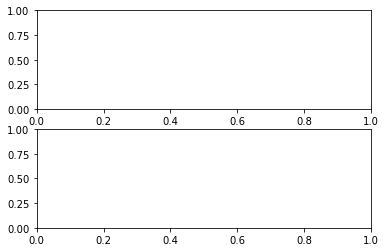

In [25]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pylab as plt
from pandas.tools.plotting import andrews_curves

fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1)

for key, grp in df.groupby(['city']): 
    #ax2.plot(grp['date'], grp['value'], label = "{}".format(key))
    print("key: {}, grp: {}".format(key, type(grp)))
    x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in grp.date.values])
    y = list(grp.value.values)
    ax2.plot(x, y, label=key)

plt.legend(loc='right')    
plt.show()

In [26]:
df.head()

,seriesid,year,month,period,date,state,city,measure,value,footnotes
0,LAUCT426000000000003,2017,August,M08,2017/08,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,Preliminary.
1,LAUCT426000000000003,2017,July,M07,2017/07,Pennsylvania,Philadelphia County/city,unemployment-rate,6.9,
2,LAUCT426000000000003,2017,June,M06,2017/06,Pennsylvania,Philadelphia County/city,unemployment-rate,6.4,
3,LAUCT426000000000003,2017,May,M05,2017/05,Pennsylvania,Philadelphia County/city,unemployment-rate,6.7,
4,LAUCT426000000000003,2017,April,M04,2017/04,Pennsylvania,Philadelphia County/city,unemployment-rate,5.9,


In [27]:
for key, grp in df.groupby(['city']):
    earliest = float(grp.sort_values(['date']).head(1).value.values[0])
    latest   = float(grp.sort_values(['date']).tail(1).value.values[0])
    print("city: {0:20s}\tearliest: {1}\t latest: {2}\tdelta: {3:-5.2f}".format(key,earliest,latest,latest-earliest))


city: Dallas city         	earliest: 4.9	 latest: 4.1	delta: -0.80
city: Philadelphia County/city	earliest: 6.9	 latest: 6.7	delta: -0.20
city: Phoenix city        	earliest: 4.8	 latest: 4.4	delta: -0.40
city: San Antonio city    	earliest: 4.2	 latest: 3.7	delta: -0.50
city: San Diego city      	earliest: 5.1	 latest: 4.5	delta: -0.60


city: Dallas city         	earliest: 4.9	 latest: 4.1	delta: -0.80
city: Philadelphia County/city	earliest: 6.9	 latest: 6.7	delta: -0.20
city: Phoenix city        	earliest: 4.8	 latest: 4.4	delta: -0.40
city: San Antonio city    	earliest: 4.2	 latest: 3.7	delta: -0.50
city: San Diego city      	earliest: 5.1	 latest: 4.5	delta: -0.60


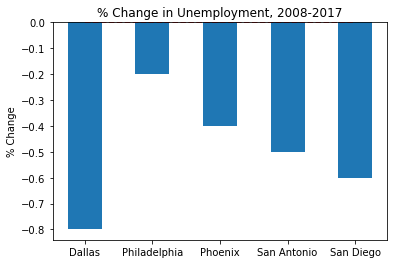

In [28]:
fig, ax = plt.subplots()

deltas = []
cities = []

for key, grp in df.groupby(['city']):
    earliest = float(grp.sort_values(['date']).head(1).value.values[0])
    latest   = float(grp.sort_values(['date']).tail(1).value.values[0])
    delta = latest-earliest
    print("city: {0:20s}\tearliest: {1}\t latest: {2}\tdelta: {3:-5.2f}".format(key,earliest,latest,delta))
    cities.append(trimCityName(key))
    deltas.append(delta)

ind = np.arange(len(deltas))
width = 0.5

ax.plot(ind, [0,0,0,0,0], "r--")
ax.bar(ind, deltas, width)

ax.set_ylabel('% Change')
ax.set_title('% Change in Unemployment, 2008-2017')
ax.set_xticks(ind)
ax.set_xticklabels((cities))


# load the national unemployment data
file created from data presented at: http://www.ncsl.org/research/labor-and-employment/national-employment-monthly-update.aspx

In [29]:
file = open("bls-national-unemployment.raw", "r")
data = []

count = 0
for line in file.readlines():
    count += 1
    line2 = re.sub(' +',' ', line.rstrip())
    fields = [f.strip() for f in line2.split("\t")]
    #print(count,fields)
    data.append(fields)
    
file.close()

In [30]:
data2 = []
for i in range(1, len(data)):
    #print(i, data[i])
    row = data[i]
    year = row[0]
    for j in range(1,len(row)):
        month = "{0:02}".format(j)
        #print(i,j,year,month,row[j])
        row2 = ["national-unemployment","{}/{}".format(year,month),row[j]]
        data2.append(row2)

In [31]:
df2 = pd.DataFrame(data2, columns=["measure","date","value"])
df2 = df2.sort_values('date')

In [32]:
df2.head()

,measure,date,value
105,national-unemployment,2008/01,4.9
106,national-unemployment,2008/02,4.8
107,national-unemployment,2008/03,5.1
108,national-unemployment,2008/04,5.0
109,national-unemployment,2008/05,5.5


# plot a city's data
(this is based on the Matplotlib example here: https://matplotlib.org/examples/api/date_demo.html )

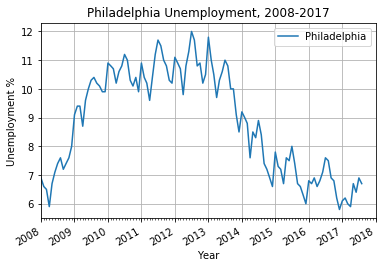

In [33]:
"""
================
Date tick labels
================

Show how to make date plots in matplotlib using date tick locators and
formatters.  See major_minor_demo1.py for more information on
controlling major and minor ticks

All matplotlib date plotting is done by converting date instances into
days since the 0001-01-01 UTC.  The conversion, tick locating and
formatting is done behind the scenes so this is most transparent to
you.  The dates module provides several converter functions date2num
and num2date

"""
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

cityName = "Philadelphia County/city"
cityData = df[df.city==cityName]
x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in cityData.date.values])
y = list(cityData.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("{} Unemployment, 2008-2017".format(trimCityName(cityName)))
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend([trimCityName(cityName)])
plt.show()

# plot the national data

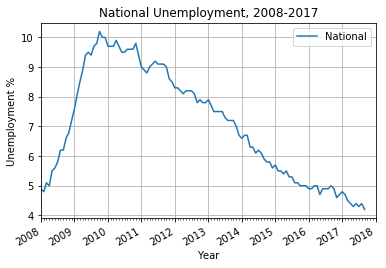

In [34]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y = list(df2.value.values)

fig, ax = plt.subplots()
ax.plot(x, y)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("National Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(['National'])
plt.show()

# plot both national and city data

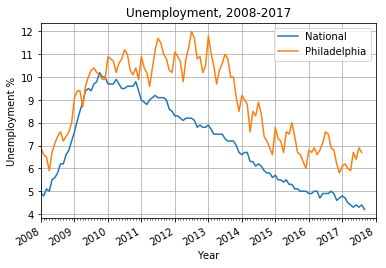

In [35]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

x1 = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y1 = list(df2.value.values)

cityName = "Philadelphia County/city"
cityData = df[df.city==cityName]
x2 = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in cityData.date.values])
y2 = list(cityData.value.values)

fig, ax = plt.subplots()
ax.plot(x1, y1, x2, y2)


# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(['National',trimCityName(cityName)])
plt.show()

# plot the national and all the fetched cities data

key: Dallas city, grp: <class 'pandas.core.frame.DataFrame'>
key: Philadelphia County/city, grp: <class 'pandas.core.frame.DataFrame'>
key: Phoenix city, grp: <class 'pandas.core.frame.DataFrame'>
key: San Antonio city, grp: <class 'pandas.core.frame.DataFrame'>
key: San Diego city, grp: <class 'pandas.core.frame.DataFrame'>


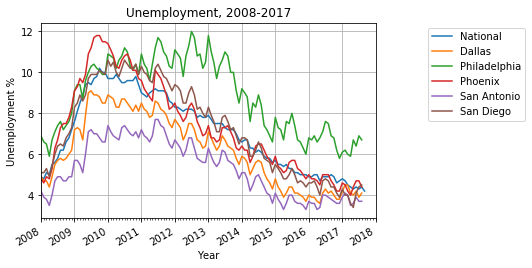

In [36]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

fig, ax = plt.subplots()

# national data
x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
y = list(df2.value.values)
ax.plot(x, y, label="National")

for key, grp in df.groupby(['city']): 
    print("key: {}, grp: {}".format(key, type(grp)))
    x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in grp.date.values])
    y = list(grp.value.values)
    ax.plot(x, y, label=trimCityName(key))
    
# format the ticks
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)
ax.xaxis.set_minor_locator(months)

datemin = datetime.date(min(x).year, 1, 1)
datemax = datetime.date(max(x).year + 1, 1, 1)
ax.set_xlim(datemin, datemax)


# format the coords message box
def price(x):
    return '%1.2f' % x
ax.format_xdata = mdates.DateFormatter('%Y-%m')
ax.format_ydata = price
ax.grid(True)

# rotates and right aligns the x labels, and moves the bottom of the
# axes up to make room for them
fig.autofmt_xdate()

plt.title("Unemployment, 2008-2017")
plt.xlabel("Year")
plt.ylabel("Unemployment %")
plt.legend(loc='upper center', bbox_to_anchor=(1.3, 1.0), ncol=1)
plt.show()

# plot a lot of things together!

city: Dallas               earliest: 4.9 latest: 4.1 delta: -0.80
city: Philadelphia         earliest: 6.9 latest: 6.7 delta: -0.20
city: Phoenix              earliest: 4.8 latest: 4.4 delta: -0.40
city: San Antonio          earliest: 4.2 latest: 3.7 delta: -0.50
city: San Diego            earliest: 5.1 latest: 4.5 delta: -0.60


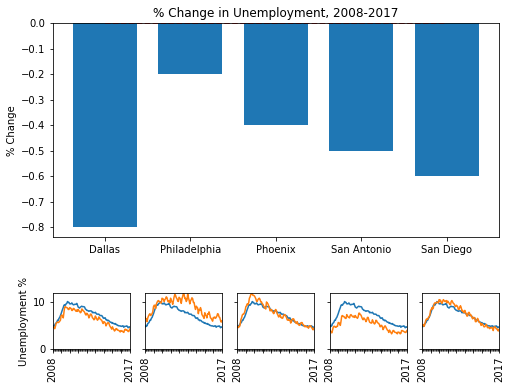

In [37]:
plt.figure(figsize=(8, 6))
axs = []
ax0 = plt.subplot2grid((6,5), (0,0), colspan=10, rowspan=4)
axs.append(plt.subplot2grid((5,5), (4,0), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,1), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,2), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,3), colspan=1))
axs.append(plt.subplot2grid((5,5), (4,4), colspan=1))

deltas = []
cities = []

for key, grp in df.groupby(['city']):
    earliest = float(grp.sort_values(['date']).head(1).value.values[0])
    latest   = float(grp.sort_values(['date']).tail(1).value.values[0])
    delta = latest-earliest
    print("city: {0:20s} earliest: {1} latest: {2} delta: {3:-5.2f}".format(trimCityName(key),earliest,latest,delta))
    cities.append(trimCityName(key))
    deltas.append(delta)

ind = np.arange(len(deltas))
width = 0.75

ax0.plot(ind, [0,0,0,0,0], "r--")
ax0.bar(ind, deltas, width)

ax0.set_ylabel('% Change')
ax0.set_title('% Change in Unemployment, 2008-2017')
ax0.set_xticks(ind)
ax0.set_xticklabels((cities))



years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

# national data
nat_x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in df2.date.values])
nat_y = list(df2.value.values)

count = -1
for key, grp in df.groupby(['city']): 
    count += 1
    #print("key: {}, grp: {}".format(key, type(grp)))
    x = list([datetime.datetime.strptime(d,'%Y/%m').date() for d in grp.date.values])
    y = list(grp.value.values)
    ax = axs[count]
    ax.plot(nat_x, nat_y, label='National')
    ax.plot(x, y, label=key)
    ax.set_ylim(0,12)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    if count >= 0:
        xtl = ax.get_xticklabels()
        for i in range(1,len(xtl)-2):
            tl = xtl[i]
            tl.set_visible(False)
    if count > 0:
        for tl in ax.get_yticklabels():
            tl.set_visible(False)
    # format the ticks
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(yearsFmt)
    ax.xaxis.set_minor_locator(months)
    # set x-axis min and max
    datemin = datetime.date(min(x).year, 1, 1)
    datemax = datetime.date(max(x).year, 1, 1)
    ax.set_xlim(datemin, datemax)
    # set a y-axis label
    if count == 0:
        ax.set_ylabel("Unemployment %")
